In [1]:
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd

In [4]:
model = read_sbml_model('../data/iML1515_5htp_2nd_strategy.xml')

**Checking max 5-HTP production and respective growth rate if objective value is changed to the 5-HTP export reaction**

In [6]:
# Finding the flux of the phhA reaction
with model:
    print(model.reactions.tph)
    model.objective = model.reactions.tph
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print("HTP flux", max_5HTP_production)
    print("Biomass flux", solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

tph: o2_c + thbpt_c + trp__L_c --> hthbpt_c + htrp_c
HTP flux 4.2792043399638375
Biomass flux 0.0


**We can see here, that when we have optimal flux towards 5-HTP production, then there will be no flux towards biomass production, thus no growth of the cell.
Let's try and optimize for both 5-HTP and biomass production**

In [7]:
# Getting the flux towards 5-HTP and biomass respectively, when optimized for both reactions
with model:
    model.objective = {model.reactions.tph: 0.5}
    solution = model.optimize()
    print("5-HTP flux", solution.objective_value)
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    print("Biomass flux", solution.objective_value)

5-HTP flux 2.1396021699819188
Biomass flux 0.43849860721348816


We can see here that the flux towards biomass and 5-HTP production are both half of their previous optimal flux, which make sense now that they share the flux

**Let's now observe how the growth rate changes with increasing 5-HTP export flux**

In [8]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [9]:
ppp_5HTP = production_envelope(model,
                    reactions=[model.reactions.tph],
                    objective=model.reactions.BIOMASS_Ec_iML1515_core_75p37M)

In [10]:
ppp_5HTP

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,tph
0,EX_glc__D_e,0.0,0.0,NaN,0.876997,1.161751e+01,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.831248,1.101147e+01,NaN,0.225221
2,EX_glc__D_e,0.0,0.0,NaN,0.785499,1.040543e+01,NaN,0.450443
3,EX_glc__D_e,0.0,0.0,NaN,0.739749,9.799397e+00,NaN,0.675664
4,EX_glc__D_e,0.0,0.0,NaN,0.694000,9.193359e+00,NaN,0.900885
5,EX_glc__D_e,0.0,0.0,NaN,0.647766,8.580901e+00,NaN,1.126106
6,EX_glc__D_e,0.0,0.0,NaN,0.601497,7.967979e+00,NaN,1.351328
7,EX_glc__D_e,0.0,0.0,NaN,0.555228,7.355058e+00,NaN,1.576549
8,EX_glc__D_e,0.0,0.0,NaN,0.508959,6.742136e+00,NaN,1.801770
9,EX_glc__D_e,0.0,0.0,NaN,0.462690,6.129215e+00,NaN,2.026992


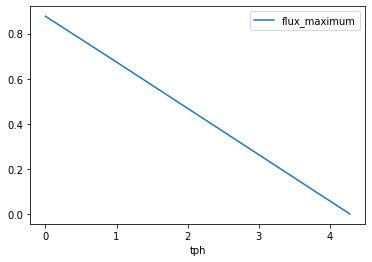

In [12]:
ppp_5HTP.plot(x='tph', y='flux_maximum')

**Optmizing 5-HTP production and growth rate**

In [13]:
from cobra.flux_analysis import flux_variability_analysis

In [14]:
hydroxy_trp_flux_analysis = flux_variability_analysis(model, model.reactions.tph, fraction_of_optimum = 0.5)
print(hydroxy_trp_flux_analysis)

     minimum   maximum
tph      0.0  2.144746


In [15]:
hydroxy_trp_flux_analysis = float(flux_variability_analysis(model, model.reactions.tph, fraction_of_optimum = 0.5)["maximum"][0])
print(hydroxy_trp_flux_analysis)

2.144746414760823


Keeping growth rate at 50%, we get around 50% of maximum 5-HTP flux, which is the same result as when optimizing for both fluxes.

**Knocking out a single gene and setting the objective value of the model for 5-HTP export flux**

Only non-zero biomass production flux knock-outs are selected

In [16]:
for gene in model.genes:
    with model:
        gene.knock_out()
        model.objective = model.reactions.tph
        solution = model.optimize()
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print ('5-HTP export flux:', solution.fluxes.tph, 'Gene ID:', gene.id, 'Biomass production:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

No solutions displayed, no single knock-outs and optmization to maximum 5-HTP production yields positive growth rate

**Knocking out a single gene, running optimisation for max biomass production flux and observing 5-HTP export flux**

Only non-zero 5-HTP export flux knock-outs are selected

In [18]:
knock_out_list = pd.DataFrame(columns=['Gene ID', '5-HTP export flux', 'Biomass production flux'])
for gene in model.genes:
    with model:
        gene.knock_out()
        solution = model.optimize()
        if solution.fluxes.tph > 0:
            knock_out_list = knock_out_list.append({ 'Gene ID': gene.id, '5-HTP export flux': solution.fluxes.phhA, 'Biomass production flux': model.optimize().objective_value}, ignore_index=True)

In [19]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(knock_out_list)

Empty DataFrame
Columns: [Gene ID, 5-HTP export flux, Biomass production flux]
Index: []


<ipython-input-19-f4d78eb1eacc>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


No solutions, no single knock-outs give rise to positive htp flux with maximum growth rate

**Check whether change of carbon source will influence the growth rate at maximum 5-HTP flux**

In [20]:
#create list to store the reactions' IDs
carbon_uptake = list()

#go through all metabolites in the model that have carbon in their chem.structure
for metabolite in model.metabolites:
    if 'C' in metabolite.elements:
        #find metabolites that are external
        if metabolite.id[-1] == 'e':
            reactions = metabolite.reactions
            #pick reactions which exchange the metabolite with the external environment
            for element in reactions:
                if str(element.id[:2]) == 'EX':
                    carbon_uptake.append(element.id)

In [21]:
for reaction in carbon_uptake:
    print(reaction, "with the name: ", model.reactions.get_by_id(reaction).name)


EX_co2_e with the name:  CO2 exchange
EX_akg_e with the name:  2-Oxoglutarate exchange
EX_gsn_e with the name:  Guanosine exchange
EX_34dhpac_e with the name:  3,4-Dihydroxyphenylacetaldehyde exchange
EX_anhgm_e with the name:  N-Acetyl-D-glucosamine(anhydrous)N-Acetylmuramic acid exchange
EX_dms_e with the name:  Dimethyl sulfide exchange
EX_galctn__L_e with the name:  L-Galactonate exchange
EX_btn_e with the name:  Biotin exchange
EX_ocdcea_e with the name:  Octadecenoate (n-C18:1) exchange
EX_acmum_e with the name:  N-Acetylmuramate exchange
EX_adocbl_e with the name:  Adenosylcobalamin exchange
EX_novbcn_e with the name:  Novobiocin exchange
EX_feenter_e with the name:  Fe-enterobactin exchange
EX_arbtn_e with the name:  Aerobactin minus Fe3 exchange
EX_gln__L_e with the name:  L-Glutamine exchange
EX_cpgn_un_e with the name:  Coprogen unloaded (no Fe(III)) exchange
EX_tre_e with the name:  Trehalose exchange
EX_alaala_e with the name:  D-Alanyl-D-alanine exchange
EX_idon__L_e with

In [22]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [24]:
medium = model.medium


#replace glucose with each exchange reaction from the possible carbon source reactions
for reaction in carbon_uptake:
    medium = model.medium
    with model:
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        model.objective = model.reactions.tph
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
            print(max_5HTP_production)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

No solutions, changing of medium does not influence the increase of growth rate at 5-HTP maximum flux production

**Again working under the assumption that the production of 5-HTP and biomass needs to be shared 50-50, we will try and go through the list of potential carbon sources to see which carbon source will increase the flux towards both 5-HTP and biomass production.**

In [26]:
# getting the max fluxes of 5-htp and biomass production on glucose
medium = model.medium
model.objective = {model.reactions.tph: 0.5}
solution = model.optimize()
glucose_max_5htp = solution.objective_value
model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
solution = model.optimize()
glucose_max_biomass = solution.objective_value
count = 0

#replace glucose with each exchange reaction from the possible carbon source reactions
for reaction in carbon_uptake:
    # resetting the media after each change
    medium = model.medium
    with model:
        # setting the medium to the new carbon source
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        # calculating max production of 5-htp and biomass
        model.objective = {model.reactions.tph: 0.5}
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
        solution = model.optimize()
        max_biomass_production = solution.objective_value
        # If the production is higher for both biomass and 5-htp production than using glucose as carbon source, then we print it
        if max_5HTP_production > glucose_max_5htp and max_biomass_production > glucose_max_biomass:
            count += 1
            print("optimal 5htp production using: ", model.reactions.get_by_id(reaction).name, "is ", max_5HTP_production)
            print("optimal biomass production using: ", model.reactions.get_by_id(reaction).name, "is ", max_biomass_production)
print("number of carbon sources which could improve 5-htp production: ", count)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Guanosine exchange is  2.4827777777777778
optimal biomass production using:  Guanosine exchange is  0.519165530976141


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  N-Acetyl-D-glucosamine(anhydrous)N-Acetylmuramic acid exchange is  6.509268292682922
optimal biomass production using:  N-Acetyl-D-glucosamine(anhydrous)N-Acetylmuramic acid exchange is  1.351185368117619


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Octadecenoate (n-C18:1) exchange is  5.925119999999993
optimal biomass production using:  Octadecenoate (n-C18:1) exchange is  1.332561626827333
optimal 5htp production using:  N-Acetylmuramate exchange is  3.6413851351351334
optimal biomass production using:  N-Acetylmuramate exchange is  0.7757145073518


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Trehalose exchange is  4.347526501766782
optimal biomass production using:  Trehalose exchange is  0.8898997641631144


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Glucose 6-phosphate exchange is  2.2281481481481578
optimal biomass production using:  D-Glucose 6-phosphate exchange is  0.4526048933681598


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  L-alanine-L-glutamate exchange is  2.418608695652174
optimal biomass production using:  L-alanine-L-glutamate exchange is  0.5218182679900039


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-fructose 6-phosphate exchange is  2.228148148148148
optimal biomass production using:  D-fructose 6-phosphate exchange is  0.45260489336816


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Octadecanoate (n-C18:0) exchange is  5.845120000000004
optimal biomass production using:  Octadecanoate (n-C18:0) exchange is  1.3145695979492356
optimal 5htp production using:  GMP exchange is  2.482777777777763
optimal biomass production using:  GMP exchange is  0.5191655309763352
optimal 5htp production using:  L-alanine-D-glutamate-meso-2,6-diaminoheptanedioate-D-alanine exchange is  3.30991304347826
optimal biomass production using:  L-alanine-D-glutamate-meso-2,6-diaminoheptanedioate-D-alanine exchange is  0.748702831014565


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Cellobiose exchange is  4.31706081081081
optimal biomass production using:  Cellobiose exchange is  0.8898997641631078
optimal 5htp production using:  D-Sorbitol exchange is  2.2351351351351347
optimal biomass production using:  D-Sorbitol exchange is  0.47141327490773866
optimal 5htp production using:  Deoxyguanosine exchange is  2.504885496183207
optimal biomass production using:  Deoxyguanosine exchange is  0.5407155427521391


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Maltotriose exchange is  6.603148148148154
optimal biomass production using:  Maltotriose exchange is  1.341300921112751
optimal 5htp production using:  3-(3-hydroxy-phenyl)propionate exchange is  2.462086956521744
optimal biomass production using:  3-(3-hydroxy-phenyl)propionate exchange is  0.5315486004280966


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  DGMP exchange is  2.5048854961832077
optimal biomass production using:  DGMP exchange is  0.5407155427521398


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  UDPglucose exchange is  4.060940325497285
optimal biomass production using:  UDPglucose exchange is  0.8432838831657016


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Xanthosine 5'-phosphate exchange is  2.459629629629628
optimal biomass production using:  Xanthosine 5'-phosphate exchange is  0.5116634035436111
optimal 5htp production using:  D-Glucosamine 6-phosphate exchange is  2.2281481481481475
optimal biomass production using:  D-Glucosamine 6-phosphate exchange is  0.4527658214050485


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Galactitol exchange is  2.1953719008264443
optimal biomass production using:  Galactitol exchange is  0.46780388972905085


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  N-Acetyl-D-mannosamine exchange is  2.6678048780487797
optimal biomass production using:  N-Acetyl-D-mannosamine exchange is  0.5656562356516576
optimal 5htp production using:  Maltose exchange is  4.380925925925926
optimal biomass production using:  Maltose exchange is  0.8898997641631173


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Mannose 6-phosphate exchange is  2.2281481481481498
optimal biomass production using:  D-Mannose 6-phosphate exchange is  0.4526048933681622
optimal 5htp production using:  Lactose exchange is  4.3577777777777715
optimal biomass production using:  Lactose exchange is  0.8851976687782269
optimal 5htp production using:  UDP-D-glucuronate exchange is  3.6209917355371886
optimal biomass production using:  UDP-D-glucuronate exchange is  0.757164205554781
optimal 5htp production using:  Decanoate (n-C10:0) exchange is  3.125120000000006
optimal biomass production using:  Decanoate (n-C10:0) exchange is  0.702840616093959


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Adenosine exchange is  2.6292561983471043
optimal biomass production using:  Adenosine exchange is  0.5529175637508863
optimal 5htp production using:  Fe(III)dicitrate exchange is  2.8255371900826436
optimal biomass production using:  Fe(III)dicitrate exchange is  0.5972626355185822
optimal 5htp production using:  DAMP exchange is  2.638473282442756
optimal biomass production using:  DAMP exchange is  0.5738131175514221


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  AMP exchange is  2.629256198347107
optimal biomass production using:  AMP exchange is  0.5529175637508862


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Phenylpropanoate exchange is  2.6051200000000034
optimal biomass production using:  Phenylpropanoate exchange is  0.5656047639614167
optimal 5htp production using:  3-hydroxycinnamic acid exchange is  2.375130434782606
optimal biomass production using:  3-hydroxycinnamic acid exchange is  0.5120879355519111
optimal 5htp production using:  L-alanine-D-glutamate-meso-2,6-diaminoheptanedioate exchange is  2.3533913043478276
optimal biomass production using:  L-alanine-D-glutamate-meso-2,6-diaminoheptanedioate exchange is  0.5283132108275695


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Deoxyadenosine exchange is  2.6384732824427446
optimal biomass production using:  Deoxyadenosine exchange is  0.5738131175514232
optimal 5htp production using:  Octanoate (n-C8:0) exchange is  2.4451199999999824
optimal biomass production using:  Octanoate (n-C8:0) exchange is  0.5499083706301365


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

optimal 5htp production using:  Glycerophosphoglycerol exchange is  2.5704635761589416
optimal biomass production using:  Glycerophosphoglycerol exchange is  0.527259416728011
optimal 5htp production using:  2(alpha-D-Mannosyl)-D-glycerate exchange is  2.9910472972972975
optimal biomass production using:  2(alpha-D-Mannosyl)-D-glycerate exchange is  0.617178231839383


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

optimal 5htp production using:  Dodecanoate (n-C12:0) exchange is  3.8051199999999974
optimal biomass production using:  Dodecanoate (n-C12:0) exchange is  0.8557728615577661


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Phenylacetaldehyde exchange is  2.465120000000007
optimal biomass production using:  Phenylacetaldehyde exchange is  0.5412789328661918


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  UDP-N-acetyl-D-glucosamine exchange is  4.5919241192411935
optimal biomass production using:  UDP-N-acetyl-D-glucosamine exchange is  0.9728152247408998
optimal 5htp production using:  Tetradecenoate (n-C14:1) exchange is  4.565120000000031
optimal biomass production using:  Tetradecenoate (n-C14:1) exchange is  1.026697135900173
optimal 5htp production using:  IMP exchange is  2.608595041322303
optimal biomass production using:  IMP exchange is  0.5472855786110221
optimal 5htp production using:  Sn-Glycero-3-phospho-1-inositol exchange is  3.0055652173913034
optimal biomass production using:  Sn-Glycero-3-phospho-1-inositol exchange is  0.6264988336240142
optimal 5htp production using:  Hexadecanoate (n-C16:0) exchange is  5.165119999999999
optimal biomass production using:  Hexadecanoate (n-C16:0) exchange is  1.1616373524853827


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Xanthosine exchange is  2.459629629629636
optimal biomass production using:  Xanthosine exchange is  0.5116634035436127
optimal 5htp production using:  Tetradecanoate (n-C14:0) exchange is  4.485120000000007
optimal biomass production using:  Tetradecanoate (n-C14:0) exchange is  1.0087051070215889


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Inosine exchange is  2.6085950413223093
optimal biomass production using:  Inosine exchange is  0.5472855786110203


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  3'-GMP exchange is  2.482777777777775
optimal biomass production using:  3'-GMP exchange is  0.519165530976337


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  N-Acetyl-D-glucosamine exchange is  2.6678048780487718
optimal biomass production using:  N-Acetyl-D-glucosamine exchange is  0.5656562356516553


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  N-Acetylneuraminate exchange is  3.556925675675679
optimal biomass production using:  N-Acetylneuraminate exchange is  0.7396956242818389


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  UDPgalactose exchange is  4.05685185185185
optimal biomass production using:  UDPgalactose exchange is  0.8384994566317342


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

optimal 5htp production using:  Maltohexaose exchange is  13.454999999999995
optimal biomass production using:  Maltohexaose exchange is  2.733121155040764
optimal 5htp production using:  DIMP exchange is  2.619389312977096
optimal biomass production using:  DIMP exchange is  0.5681660040012937


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Hexadecenoate (n-C16:1) exchange is  5.2451199999999885
optimal biomass production using:  Hexadecenoate (n-C16:1) exchange is  1.179629381363513
optimal 5htp production using:  Reduced glutathione exchange is  2.668608695652187
optimal biomass production using:  Reduced glutathione exchange is  0.5883626832481184


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  3'-AMP exchange is  2.6292561983471074
optimal biomass production using:  3'-AMP exchange is  0.5529175637508851
optimal 5htp production using:  1,4-alpha-D-glucan exchange is  13.455
optimal biomass production using:  1,4-alpha-D-glucan exchange is  2.7331211550407737
optimal 5htp production using:  Maltopentaose exchange is  11.140185185185198
optimal biomass production using:  Maltopentaose exchange is  2.2629116165103413


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Melibiose exchange is  4.357777777777785
optimal biomass production using:  Melibiose exchange is  0.8851976687782201
optimal 5htp production using:  Maltotetraose exchange is  8.825370370370372
optimal biomass production using:  Maltotetraose exchange is  1.792702078062375


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  N-Acetyl-D-glucosamine 1-phosphate exchange is  2.667804878048779
optimal biomass production using:  N-Acetyl-D-glucosamine 1-phosphate exchange is  0.5656562356516532
optimal 5htp production using:  L-alanine-D-glutamate exchange is  2.4186086956521735
optimal biomass production using:  L-alanine-D-glutamate exchange is  0.521818267989999


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Phenethylamine exchange is  2.465120000000025
optimal biomass production using:  Phenethylamine exchange is  0.5412789328661886


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  2',3'-Cyclic GMP exchange is  2.4827777777777778
optimal biomass production using:  2',3'-Cyclic GMP exchange is  0.5191655309763334


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Deoxyinosine exchange is  2.6193893129770975
optimal biomass production using:  Deoxyinosine exchange is  0.5681660040012962
optimal 5htp production using:  2',3'-Cyclic AMP exchange is  2.629256198347108
optimal biomass production using:  2',3'-Cyclic AMP exchange is  0.5529175637508853


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Mannitol exchange is  2.2351351351351343
optimal biomass production using:  D-Mannitol exchange is  0.47141327490773133
number of carbon sources which could improve 5-htp production:  68


68 carbon uptake reaction can increase the flux towards both biomass and 5-HTP production

## Yield calculations

**Calculating the max theoretical yeild of 5-HTP**

In [27]:
from cobra.flux_analysis import flux_variability_analysis

In [34]:
with model:
    # calculating max yield of 5-HTP
    substrate_flux = model.reactions.EX_glc__D_e.flux
    model.objective = model.reactions.EX_htrp
    max_5htp_production = model.optimize().objective_value
    print("the flux of 5htp production: ",max_5htp_production , "[mmol gDW^-1 h^-1]")
    # calculating molar yield
    molar_yield_5htp = max_5htp_production / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glc]")
    # Defining mass yield
    M_5htp = 0.22023 # g/mmol
    M_glc = 0.180156 # g/mmol
    mass_yield_5htp = max_5htp_production * M_5htp / (-1. * substrate_flux)*M_glc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glucose: C6H12O6 
    cmol_glc = M_glc/6
    cmol_yield_5htp = mass_yield_5htp * (cmol_glc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glc]")
    

the flux of 5htp production:  4.279204339963839 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.4279204339963839 [mmol-5htp / mmol-glc]
The mass yield of 5htp  0.016978066675304184 [g-5htp / g-glc]
The c-cmol yield of 5thp  0.02546255155936756 [cmol-5htp / cmol-glc]


In [35]:
model.reactions.EX_glyc_e

Reaction identifier,EX_glyc_e
Name,Glycerol exchange
Memory address,0x07f82e3a77910
Stoichiometry,glyc_e --> Glycerol -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [36]:
medium = model.medium
with model:
    #replace glucose with glycerol
    medium['EX_glc__D_e'] = 0
    medium["EX_glyc_e"] = 10
    model.medium = medium
    model.objective = model.reactions.EX_htrp
    solution = model.optimize()
    print("the flux of 5htp production: ",solution.fluxes["EX_htrp"] , "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = solution.fluxes['EX_htrp'] / (-1. * solution.fluxes['EX_glyc_e'])
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glyc]")
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_glyc = 92.09/1000 # g/mmol
    mass_yield_5htp = solution.fluxes['EX_htrp']* M_5htp / (-1. * solution.fluxes['EX_glyc_e'])* M_glyc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glyc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glycerol: C3H8O3 
    cmol_glyc = M_glyc/3
    cmol_yield_5htp = mass_yield_5htp * (cmol_glyc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glyc]")

the flux of 5htp production:  2.440761904761903 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.24407619047619028 [mmol-5htp / mmol-glyc]
The mass yield of 5htp  0.004950104508377139 [g-5htp / g-glyc]
The c-cmol yield of 5thp  0.00758965076804698 [cmol-5htp / cmol-glyc]


**Calculating yield at 50% growth**

In [38]:
# Calculating the yield of 5-HTP and biomass on glucose carbon source
medium = model.medium

with model:
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.tph: 0.5}
    solution = model.optimize()
    glucose_max_5htp = solution.objective_value
    substrate_flux = solution.fluxes['EX_glc__D_e']
    print("the flux of 5htp production: ",glucose_max_5htp, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = glucose_max_5htp / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    # defining mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_glc = 180.156/1000 # g/mmol
    glucose_mass_yield_5htp = glucose_max_5htp*M_5htp / (-1. * substrate_flux)*M_glc
    print("The mass yield of 5htp ", glucose_mass_yield_5htp , "[g-5htp / g-Sub]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glucose: C6H12O6 
    cmol_glc = M_glc/6
    cmol_yield_5htp = glucose_mass_yield_5htp * (cmol_glc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    glucose_max_biomass = solution.objective_value
    print("the flux of biomass production: ",glucose_max_biomass, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = glucose_max_biomass / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    glucose_mass_yield_biomass = glucose_max_biomass*M_biomass / (-1. * substrate_flux)*M_glc
    print("The mass yield of biomass ", glucose_mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = glucose_mass_yield_biomass * (cmol_glc / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  2.1396021699819197 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.21396021699819195 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.00848903333765209 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.01273127577968378 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.4384986072134869 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.04384986072134869 [mmol-X / mmol-Sub]
The mass yield of biomass  0.00019433546149963624 [g-X / g-Sub]
The c-cmol yield of biomass  0.0002371998604466698 [cmol-X / cmol-Sub]


**Replace glucose with glycerol**

In [41]:
medium = model.medium

with model:
    #replace glucose with glycerol
    medium['EX_glc__D_e'] = 0
    medium["EX_glyc_e"] = 10
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.tph: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_glyc_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_sub = 92.09/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glycerol: C3H8O3 
    cmol_sub = M_sub/3
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  1.2203809523809515 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.12203809523809514 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.0024750522541885697 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.00379482538402349 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.24735674620895284 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.024735674620895286 [mmol-X / mmol-Sub]
The mass yield of biomass  5.6036543585620876e-05 [g-X / g-Sub]
The c-cmol yield of biomass  6.992419104064805e-05 [cmol-X / cmol-Sub]


**Replace glucose with sucrose**

In [42]:
medium = model.medium

with model:
    #replace glucose with sucrose
    medium['EX_glc__D_e'] = 0
    medium["EX_sucr_e"] = 10
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.tph: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_sucr_e']
    print(substrate_flux)
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of sucrose
    M_sub = 342.29/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # sucrose: C12H22O11 
    cmol_sub = M_sub/12
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
<ipython-input-42-fd1b12ee6709>:16: RuntimeWarning: invalid value encountered in double_scalars
  molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
<ipython-input-42-fd1b12ee6709>:23: RuntimeWarning: invalid value encountered in double_scalars
  mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub


0.0
the flux of 5htp production:  0.0 [mmol gDW^-1 h^-1]
The molar yield of 5htp  nan [mmol-5htp / mmol-Sub]
The mass yield of 5htp  nan [g-5htp / g-Sub]
The c-cmol yield of 5thp  nan [cmol-5htp / cmol-Sub]
the flux of biomass production:  -0.021731826526236737 [mmol gDW^-1 h^-1]
The molar yield of biomass  inf [mmol-X / mmol-Sub]
The mass yield of biomass  inf [g-X / g-Sub]
The c-cmol yield of biomass  inf [cmol-X / cmol-Sub]


<ipython-input-42-fd1b12ee6709>:39: RuntimeWarning: divide by zero encountered in double_scalars
  molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
<ipython-input-42-fd1b12ee6709>:45: RuntimeWarning: divide by zero encountered in double_scalars
  mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub


**Replace glucose with lactose**

In [43]:
medium = model.medium

with model:
    #replace glucose with lactose
    medium['EX_glc__D_e'] = 0
    medium["EX_lcts_e"] = 10
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.tph: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_lcts_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of lactose
    M_sub = 342.3/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # lactose: C12H22O11 
    cmol_sub = M_sub/12
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  4.357777777777778 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.43577777777777776 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.032850989681999995 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.046804791751666665 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.8851976687782261 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.08851976687782262 [mmol-X / mmol-Sub]
The mass yield of biomass  0.0007453877785760555 [g-X / g-Sub]
The c-cmol yield of biomass  0.0008643165196699993 [cmol-X / cmol-Sub]


**Replace glucose with galactose**

In [46]:
medium = model.medium

with model:
    #replace glucose with lactose
    medium['EX_glc__D_e'] = 0
    medium["EX_gal_e"] = 10
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.tph: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_gal_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of galactose
    M_sub = 180.16/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # galactose: C6H12O6 
    cmol_sub = M_sub/6
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  2.1355555555555554 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.21355555555555555 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.008473166214399998 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.01270776148954074 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.4337965118285891 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.04337965118285891 [mmol-X / mmol-Sub]
The mass yield of biomass  0.000192255837744755 [g-X / g-Sub]
The c-cmol yield of biomass  0.00023466674612530525 [cmol-X / cmol-Sub]


**Replace glucose with Fructose**

In [45]:
medium = model.medium

with model:
    #replace glucose with fructose
    medium['EX_glc__D_e'] = 0
    medium["EX_fru_e"] = 10
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.tph: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_fru_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of fructose
    M_sub = 180.16/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # fructose: C6H12O6 
    cmol_sub = M_sub/6
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  2.0873310810810817 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.20873310810810816 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.008281827718540542 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.01242079863437838 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.43849860721348277 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.04384986072134828 [mmol-X / mmol-Sub]
The mass yield of biomass  0.0001943397763259294 [g-X / g-Sub]
The c-cmol yield of biomass  0.00023721039365094467 [cmol-X / cmol-Sub]
